## Imports used and general plan for classifier

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import matplotlib.pyplot as plt
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import itertools 
from sklearn.model_selection import train_test_split
import re
import tokenize
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords, wordnet
from collections import defaultdict
from nltk.tokenize import TweetTokenizer
import tqdm
from tqdm.notebook import tqdm 
import time
import random
import pickle
nltk.download('wordnet')

#  GENERAL PLAN: 
"""
When importing new libraries make sure they are in a packge in ondemand environment or else it won't work
Libraries:

Textblob (Sentiment Classifier)
Tweepy (Tweepy Stopwords remover, it won't remove all the punctuations)
Tensorflow / Pytorch
Spacy to get the POS, Named Entity Recognition (To get more features)

Approach: Data is unbalanced
You need to balance the data to make the training valid

Step 1:
Data Exploratory:
Check for null values, missing values
Make some graph to show the imbalance

Step 2:
Split the data into training and validation (80 and 20)

Step 3:
Preprocessing the data
 0) Make into Lowercase
 1) Keep the punctuation to test how our model works and vice versa (Try to reomve unneccessary punctuation like ##)
 2) Try Stemming and Lemmatization
 3) Stopwords can be removed if we are not using contextualized embeddings like BERT
 4) Try to remove the numbers it doesn't make sense

Step 4:
Balancing technique: 
SMOTE(imblearn) --> geenrate the synthetic data
pandas Resample - oversample and undersample
try xgboost without oversampling and undersampling

Step 5:
Feature Engineering
If we are not using the contextualized embeddings we can split into Bigrams and unigrams

Step 6:
Modeling
Naive Bayes or Decision Tree or Random Forest (Creating a baseline model)
Xgboost
BERT (if we are not removing the stopwords)
Try Neural Network models for classification (eg. LSTM)

Step 7:
IF time is available try to implement sequential feature selector to remove the unnecessary features (Unigram, Bigram, Trigram, Parts_Of_Speech_Unigram)
Calculate the Macro Average as the class is unbalanced and also Macro Precision, Recall and F1 score

Step 8:
Perform Cross Validation to reduce over fitting of the model and increase the variance of the model

Step 9:
Hypertune the model by finding the right parameters (Grid Search is one way but leads to high time complexity)

Step 10:
Save the model in a pickle file

"""

[nltk_data] Downloading package wordnet to /home/kql5923/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


"\nWhen importing new libraries make sure they are in a packge in ondemand environment or else it won't work\nLibraries:\n\nTextblob (Sentiment Classifier)\nTweepy (Tweepy Stopwords remover, it won't remove all the punctuations)\nTensorflow / Pytorch\nSpacy to get the POS, Named Entity Recognition (To get more features)\n\nApproach: Data is unbalanced\nYou need to balance the data to make the training valid\n\nStep 1:\nData Exploratory:\nCheck for null values, missing values\nMake some graph to show the imbalance\n\nStep 2:\nSplit the data into training and validation (80 and 20)\n\nStep 3:\nPreprocessing the data\n 0) Make into Lowercase\n 1) Keep the punctuation to test how our model works and vice versa (Try to reomve unneccessary punctuation like ##)\n 2) Try Stemming and Lemmatization\n 3) Stopwords can be removed if we are not using contextualized embeddings like BERT\n 4) Try to remove the numbers it doesn't make sense\n\nStep 4:\nBalancing technique: \nSMOTE(imblearn) --> geenr

### Testing with the set, learning set

In [2]:
# looking at file length, value counts of emotions to see how to balance
full_file = pd.read_csv("T1_train.csv")
print(full_file['label'].values)
full_file_len = len(full_file)


['gratitude' 'gratitude' 'admiration' ... 'neutral' 'neutral' 'curiosity']


## Preprocessing of set

In [3]:
"""
Step 3:
Preprocessing the data
 0) Make into Lowercase
 1) Keep the punctuation to test how our model works and vice versa (Try to reomve unneccessary punctuation like ##)
 2) Try Stemming and Lemmatization
 3) Stopwords can be removed if we are not using contextualized embeddings like BERT
 4) Try to remove the numbers it doesn't make sense

"""
def preprocess_each_line(corpus_df_text_line, corpus_df):
  # THIS APPORACH HARDER TO FACTOR IN EMOTION OF NEUTRAL, HAVE TO GO BACK TO DO
  ### print(corpus_df_text_line)
  new_text_line = ""
  tag_map = defaultdict(lambda : wordnet.NOUN)
  tag_map['J'] = wordnet.ADJ
  tag_map['V'] = wordnet.VERB
  tag_map['R'] = wordnet.ADV
  new_corpus_line = corpus_df_text_line

  # lower case
  new_corpus_line = new_corpus_line.lower()

  # remove numbers
  new_corpus_line = re.sub(r'[0-9]', '', new_corpus_line)

  # Remove [NAME] token manually
  new_corpus_line = new_corpus_line.replace("[name]", '')

  # Remove punc
  new_corpus_line = re.sub(r'[^\w\s]', '', new_corpus_line)

  # tokenize with tweet tokenizer (keeps contractions not split to remove later)
  tokenizer = TweetTokenizer()
  new_corpus_line = tokenizer.tokenize(new_corpus_line)
  # Filter out stop words
  stop_words = set(stopwords.words('english'))
  new_corpus_line = [word for word in new_corpus_line if word not in stopwords.words('english')]

  # Lemantize with word net
  
  lmtzr = WordNetLemmatizer()
  for token, tag in nltk.pos_tag(new_corpus_line):
      lemma = lmtzr.lemmatize(token, tag_map[tag[0]])
      #print(token, "=>", lemma)
      if token != lemma:
          if token in new_corpus_line:
              index = new_corpus_line.index(token)
              new_corpus_line[index] = lemma
    # Final filter for bad punctuation
  bad_punc = [',','','.','-', '\'', '"', '’', '”', '“', ">", '`', ''] #convert to regex when not mad at regex
  new_corpus_line = [token for token in new_corpus_line if token not in bad_punc]
  ### print(new_corpus_line)
  
  new_corpus_line = ' '.join(new_corpus_line)
  return new_corpus_line
def preprocess(corpus_df, exclude_neutral = False):
  #tqdm.pandas()
  running_count = 0
  tqdm.pandas()
  print('[PREPROCESSING] starting...')
  print('[PREPROCESSING] set before preprocessing:')
  print(corpus_df['text'])
  print(corpus_df['label'].value_counts())
  print(f'[PREPROCESSING] starting preprocess on set of size {len(corpus_df)}')
  corpus_df['text'] = corpus_df['text'].progress_apply(lambda x: preprocess_each_line(x, corpus_df))
  corpus_df = corpus_df[corpus_df['text'].str.len() > 0]
  corpus_df.reset_index(inplace=True)
  print('[PREPROCESSING] done!')
  # MAYBE REMOVE?
  #corpus_df.drop_duplicates()
  print('[PREPROCESSING] set after process:')
  print(corpus_df['text'])
  print(corpus_df['label'].value_counts())
  if exclude_neutral:
    corpus_df = corpus_df[corpus_df["label"].str.contains("neutral")==False]
  return corpus_df


# Demonstration of preprocessing working
temp_whole_corpus = pd.read_csv("T1_train.csv")
print(type(temp_whole_corpus))

print(temp_whole_corpus)
preprocessed_whole_corpus = preprocess(temp_whole_corpus)
print(preprocessed_whole_corpus)


<class 'pandas.core.frame.DataFrame'>
                                                   text       label
0                        Thank you all for the insight.   gratitude
1     I am already using ublock. Thank you for sugge...   gratitude
2                                       That’s awesome!  admiration
3                                               True :/     neutral
4              Also likely selling stolen goods too lol   amusement
...                                                 ...         ...
6527     Knicks fans chanting lets go heat is sickening     neutral
6528                                         Goddam it!       anger
6529  Those charts seem to indicate approximately a ...     neutral
6530                                   That'll cost ya.     neutral
6531    Question for [NAME] the incentive to work hard?   curiosity

[6532 rows x 2 columns]
[PREPROCESSING] starting...
[PREPROCESSING] set before preprocessing:
0                          Thank you all for the in


[PREPROCESSING] done!
[PREPROCESSING] set after process:
0                                           thank insight
1       already use ublock thank suggest ghostery didn...
2                                           thats awesome
3                                                    true
4                         also likely sell steal good lol
                              ...                        
6485               knicks fan chant let go heat sickening
6486                                               goddam
6487    chart seem indicate approximately net advantag...
6488                                       thatll cost ya
6489                         question incentive work hard
Name: text, Length: 6490, dtype: object
neutral       2576
gratitude     1255
admiration     818
love           458
amusement      388
curiosity      250
approval       236
anger          176
optimism       175
sadness        158
Name: label, dtype: int64
      index                                     

## Splitting of test and train (test function to show steps)

In [4]:
# demonstration function of how to split set, in actual implementation just calling train_test_split
def split_set(file_to_split):
    print(f'[SPLITTING SET]')
    full_data = pd.read_csv(file_to_split)
    
    all_emotionlabels = full_data['label'] # x
    all_texts = full_data['text'] # y
    
    emotionlabels_train, emotionlabels_test, texts_train, texts_test = train_test_split(all_emotionlabels, all_texts, train_size=.8, shuffle=False)

    return emotionlabels_train, texts_train, emotionlabels_test, texts_test
    
  
    
    
emotionlabels_train, texts_train, emotionlabels_test, texts_test = split_set("T1_train.csv")
print("------------------ TRAIN SET ------------------")

print(emotionlabels_train.value_counts())
print(texts_train)
print("------------------ TEST SET ------------------")
print(emotionlabels_test.value_counts())
print(texts_test)

"""
print(len(train_set['label']))
print(train_set['label'].value_counts())
print(len(test_set['label']))
print(test_set['label'].value_counts())
"""


[SPLITTING SET]
------------------ TRAIN SET ------------------
neutral       2092
gratitude     1025
admiration     645
love           352
amusement      314
curiosity      205
approval       186
optimism       144
anger          142
sadness        120
Name: label, dtype: int64
0                          Thank you all for the insight.
1       I am already using ublock. Thank you for sugge...
2                                         That’s awesome!
3                                                 True :/
4                Also likely selling stolen goods too lol
                              ...                        
5220    She looks like her face is pulled back with ''...
5221                 i really hope this is old and ironic
5222    Everyone started making remakes. Here is my fa...
5223       love ya bro, i just love how positive you are!
5224    Thanks for sharing. They also have an Amazon w...
Name: text, Length: 5225, dtype: object
------------------ TEST SET --------------

"\nprint(len(train_set['label']))\nprint(train_set['label'].value_counts())\nprint(len(test_set['label']))\nprint(test_set['label'].value_counts())\n"

## Full System / EmotionClassifier

In [5]:
#!python3.6 -m pip install seaborn

In [6]:
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
#####################  EmotionClassifier  #####################

# FINAL SYSTEM -- This can be put into a python file and run as imported object

##################################################################################
import pandas as pd
import numpy as np
from scipy.stats import randint
import matplotlib.pyplot as plt
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import itertools 
from sklearn.model_selection import train_test_split
import re
import tokenize
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords, wordnet
from collections import defaultdict
from nltk.tokenize import TweetTokenizer
import tqdm
from tqdm.notebook import tqdm 
import time
import random
import pickle
#import seaborn as sns

# ----------------------- HELPER FUNCTIONS -------------------------------

def pickle_object_save(object, filename):
    # Function to save entire classifier object as pickle file
  with open(filename, 'wb') as outp:  # Overwrites any existing file.
    pickle.dump(object, outp, pickle.HIGHEST_PROTOCOL)

'''
def pretty_print(self,type_info,location, information):
    # function to indent and print in nice way, just for formatting/consistency
    print_str = f'[EC - {type_info}:{location}]'
    padlen = 25
    for counter in range(0, padlen-len(print_str)):
      print_str += ' '
    print_str += f'--: {information}'
    print(print_str)
'''



    
# --------------------- EMOTIONCLASSIFIER Object -------------------------------------
class EmotionClassifier:
    # MAIN emotion classifier object
    # Functions:
    #     init: initalize object 
    #     prettyprint: formatting pretty function 
    #     preprocess_test_corpus: function to take in csv file name, and output preprocessed dataframe
    #     test_model: function to take generated model and use it to predict on test
    #     print_training_stats: output function to print results from saved parameters
    #     oversample: function to oversample a df given a df (balancing)
    #     [NOT USED] generate_prediction_classreport : function to generate classreport from metrics library
    #     [NOT USED] generate_acc_wcv: function to use cross validation (5 fold) to generate accuracy
    #     train_model: main function to train and generate model using linear SVC given a preprocessed corpus
    #     predict_emotion: helper function to predict given trained model and a text
    #     validate_train: function to validate training model based on using proportion of train to test 
    #     preprocess: MAIN preprocessing function runner, will loop through each line of corpus and preprocess
    #     preprocess_each_line : main preprocessing subfunction, will take a line and output preprocessed version
    #     determine_baseline_acc : function to determine baseline accuracy given a pd.series
    # Sources: 
    #         https://www.analyticsvidhya.com/blog/2021/11/a-guide-to-building-an-end-to-end-multiclass-text-classification-model/
    #         ttps://stackoverflow.com/questions/34714162/preventing-splitting-at-apostrophies-when-tokenizing-words-using-nltk
    #         https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    #         https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-create-a-multilabel-svm-classifier-with-scikit-learn.md
    #         https://towardsdatascience.com/multi-label-text-classification-with-scikit-learn-30714b7819c5
    #         https://medium.com/analytics-vidhya/undersampling-and-oversampling-an-old-and-a-new-approach-4f984a0e8392
    
  def pretty_print(self,type_info,location, information):
    # function to indent and print in nice way, just for formatting/consistency
    print_str = ''
    print_str = f'[EC - {type_info}:{location}]'
    padlen = 25
    for counter in range(0, padlen-len(print_str)):
        print_str += ' '
    
    print_str += f'--: {information}'
    print(print_str)
        
  def __init__(self, train_file_name, test_file_name, test_file = False, exclude_neutral=False):
    
    # init: initalization function for obj
    #      train_file_name (csv file for train)
    #      test_file_name (usally empty, but filename if recieved)
    #      test_file = false (simple boolean statement to see if test file)
    #      exclude_neutral (parameter to generate train based on neutrals, defaults to false)
    #   Init will preprocess the sets to then be ready to call train function
    
    self.test_models = [
        # All models we were testing, used LinearSVC in final model, this is redundant and not actually used
        #RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0, class_weight="balanced"),
        LinearSVC()
        #MultinomialNB(),
        #LogisticRegression(random_state=0),
    ]

    self.pretty_print('START', 'INIT', 'Initalizing Emotion Classifier...')
    self.pretty_print('NLTK', 'INIT', 'Downloading NLTK Data...')
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    nltk.download('stopwords')
    nltk.download('averaged_perceptron_tagger')
    time.sleep(1)
    self.train_corpus = pd.read_csv(train_file_name)
    self.test_corpus = test_file_name # will be given this later
    self.pretty_print('NLTK', 'INIT', 'NLTK Data Download Complete!')
    if exclude_neutral:
      self.pretty_print('INFO', 'INIT', 'Preforming Pre-processing on train corpus (w/o neutral labels)...')
    
      self.train_corpus_preproccessed = self.preprocess(self.train_corpus, exclude_neutral=True)
    else:
      self.pretty_print('INFO', 'INIT', 'Preforming Pre-processing on train corpus...')
      self.train_corpus_preproccessed = self.preprocess(self.train_corpus)
    
    # Initalize Parameters
    self.ex_neutral = exclude_neutral
    #self.train_model = None
    self.trained_model = None
    self.model_acc_info = None
    self.model_acc_train = None
    self.model_acc_predict = None
    self.model_classreport_train = None
    self.model_classreport_predict = None
    self.model_prediction_results = None
    self.train_model_fitted_vectorizer = None
    self.train_model_x_validate = None
    self.train_model_y_validate = None
    self.train_model_x_train = None
    self.train_model_y_train = None
    self.model_validation_predictions = None
    
    self.test_corpus = None
    self.test_packed_results = None
    self.corpus_baseline_acc_train = None
    self.corpus_baseline_acc_validate = None
    self.corpus_baseline_acc_test = None
    self_model_train_confusionmatrix = None
    self.label_id_df = None
    self.pretty_print('DONE', 'INIT', 'Initalization complete')



  def preprocess_test_corpus(self, test_filename, exclude_neutral = False):
    # preprocess_test_corpus: function to take in csv file name, and output preprocessed dataframe
    #      test_filename : filename of test set
    #      exclude_neutral : parameter to include neutral in test set or not
    #   
    
    self.test_corpus = self.preprocess(pd.read_csv(test_filename), exclude_neutral)
    
  def determine_baseline_acc(self, series):
    # determine_baseline_acc: function to determine baseline label acc
    #      series : a pd.series to test label percent
    #  will count each occorence of mean (most labeled) label, and whichever match is baseline
    self.pretty_print('START', 'det_baseline_acc', 'Starting Baseline Reading')
    # corpus should be preprocessed here
    #print(self.train_corpus_preproccessed['label'].value_counts())
    #mode = self.train_corpus_preproccessed['label'].mode()
    mode = series.mode()
    #print(mode[0])
    baseline_label_count = 0
    total_label_count = 0
    for emotion_label in series:
        if emotion_label == mode[0]:
            baseline_label_count +=1 
        total_label_count +=1
    #print(baseline_label_count)
    baseline_acc = (baseline_label_count / total_label_count) * 100
    
    self.pretty_print('DONE', 'det_baseline_acc', 'Done with baseline acc stat')
    return baseline_acc
    
  def test_model(self, c_mx = False):
    # test_model: function to take generated model and use it to predict on test
    #      self (grabs parameters from obj)
    #   will print out resutls including accuracy, macro acc, recall, precision, f1
    self.pretty_print('START', 'TEST_MODEL', 'Starting Test')
    prediction_entries = []
    predicted_labels = []
    self.corpus_baseline_acc_test = self.determine_baseline_acc(self.test_corpus['label'])
    for (text, emotionlabel) in itertools.zip_longest(self.test_corpus['text'], self.test_corpus['label']):
      labeled_emotion = emotionlabel
      predicted_emotion = self.predict_emotion(text)
      result = (text, labeled_emotion, predicted_emotion[0])
      predicted_labels.append(predicted_emotion[0])
      prediction_entries.append(result)
    soft_count = 0
    err_count = 0
    for each in prediction_entries:
      soft_count +=1 
      #print(each)
      if each[1] != each[2]:
        err_count +=1 
    accuracy = str((1-(err_count/soft_count)) * 100)
    #self.model_prediction_results = [soft_count, err_count, accuracy]
    
    self.pretty_print('DONE', 'TEST_MODEL', 'Testing Complete!')
    
    self.pretty_print('INFO', 'TEST_MODEL', 'Results from classifier')
    class_report_predict = metrics.classification_report(self.test_corpus['label'], predicted_labels, target_names= self.test_corpus['label'].unique())
    print(class_report_predict)
    
    print(f'\t\t TOTAL PREDICTIONS: {soft_count}')
    print(f'\t\t INCORRECT PREDICTIONS: {err_count}')
    print(f'\t\t OVERALL ACCURACY: {accuracy}')
    # change to whichever correct
    baseline_acc = self.corpus_baseline_acc_test
    improvment_over_baseline = float(accuracy)-baseline_acc
    print(f'\t\t BASELINE ACCURACY: {baseline_acc}')
    print(f'\t\t IMPROVMENT OVER BASELINE: {str(improvment_over_baseline)}')
    

    # self.test_corpus['label'] = y_label
    # predicted_labels = y_pred
    if c_mx:
      import matplotlib.pyplot as plt
      from sklearn.metrics import plot_confusion_matrix
      from sklearn.metrics import confusion_matrix

      '''
      confusion_matrix =  pd.crosstab(self.test_corpus['label'], predicted_labels, rownames=self.test_corpus['label'].values, colnames=self.test_corpus['label'].values)

      print(confusion_matrix)
      '''
      
      conf_mx = confusion_matrix(self.test_corpus['label'], predicted_labels )
      conf_obj = ConfusionMatrixDisplay(conf_mx, display_labels=['>30 & None', '<30'])
      conf_obj.plot()
      #conf_obj.ax.set(title='Confusion Matrix')
      plt.show()

      

      """
      color = 'white'
      conf_matrix = confusion_matrix(self.test_corpus['label'], predicted_labels)
      conf_matrix.ax.set_title('Confusion Matrix', color=color)
      plt.xlabel('Predicted Label', color=color)
      plt.ylabel('True Label', color=color)
      plt.gcf().axes[0].tick_params(colors=color)
      plt.gcf().axes[1].tick_params(colors=color)
      plt.show()
      if self.ex_neutral == True:
        plt.title("CONFUSION MATRIX - WITHOUT NEUTRALS", size=16);
      else:
        plt.title("CONFUSION MATRIX - WITH NEUTRALS", size=16);

    self.test_packed_results = [soft_count, err_count, accuracy, class_report_predict]
    self.test_packed_results = [soft_count, err_count, accuracy, class_report_predict]
      """
    
    
  def print_training_stats(self):
    # print_training_stats: output function to print results from saved parameters
    #       self: grab vars from object to use
    #    will output info on sets before and after, and validation using 20% of train set as test set
    self.pretty_print('START', 'TRAININGSTATS', 'Printing Training Stats')
    print("\t\t -- Preprocessed Training Corpus --")
    print(self.train_corpus_preproccessed)
    print('\n')
    print("\t\t -- X_train, Y_train --")
    print(self.train_model_x_train)
    print(self.train_model_y_train)
    print("\n")
    print("\t\t -- x_validate, y_validate --")
    print(self.train_model_x_validate)
    print(self.train_model_y_validate)
    print("\t\t -- Validation Results (Class report, Accuracy, etc) --")
    print(self.model_classreport_predict)
    print (f'\t Total Classifications durring validation : {self.model_prediction_results[0]}')
    print (f'\t Incorrect Classifications durring validation : {self.model_prediction_results[1]}')
    print (f'\t Total (basic) Classification Accuracy: {self.model_prediction_results[2]}')
    print(f'\t 3 examples of classified data results (text, predicted label, actual label):')
    for counter in range(0,3):
      print('\t ', end='')
      print(f'{random.choice(self.model_validation_predictions)} \n')
    self.pretty_print('DONE', 'TRAININGSTATS', 'Done with training stat output')




  def oversample(self,df):
      # oversample: function to oversample a df given a df (balancing)
      #      df: dataframe read from csv, will be preprocessed
      #   outputs a dataframe upsampled
      self.pretty_print('START', 'OVERSAMPLER', 'Starting Oversampling...')
      classes = df.label.value_counts().to_dict()
      most = max(classes.values())
      classes_list = []
      for key in classes:
          classes_list.append(df[df['label'] == key]) 
      classes_sample = []
      for i in range(1,len(classes_list)):
          classes_sample.append(classes_list[i].sample(most, replace=True))
      df_maybe = pd.concat(classes_sample)
      final_df = pd.concat([df_maybe,classes_list[0]], axis=0)
      final_df = final_df.reset_index(drop=True)
      #print(final_df.label.value_counts())
      self.pretty_print('DONE', 'OVERSAMPLER', 'Oversampler complete!')
      return final_df

  def generate_prediction_classreport(self, features, labels, df_preprocessed_corpus):
    # generate_prediction_classreport : function to generate classreport from metrics library
    #      features : features generated in train func, pandas series
    #      labels : labels generated in train func, pandas series
    #      df_preprocessed_corpus : entire preprocessed corpus
    #    will set model_classreport_train var to class report -> FUNCTION NOT REALLY NEEDED IN END IMPLEMENTATION
    # info on training accuracy
    
    X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, labels, df_preprocessed_corpus.index, test_size=0.25, random_state=1)
    model = LinearSVC()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    self.model_classreport_train = metrics.classification_report(y_test, y_pred, target_names= df_preprocessed_corpus['label'].unique())
    

  def generate_acc_wcv(self, model, features, labels):
    # generate_acc_wcv: function to use cross validation (5 fold) to generate accuracy
    #      model: model being used for stats
    #      features : features of model
    #      labels : labels of model
    #   outputs acc, which is accuracy dataframe containing cross_val_score -> not really used in end emp
    #print(features)
    #print(labels)
    CV = 5
    cv_df = pd.DataFrame(index=range(CV * len(self.test_models)))
    entries = []
    self.pretty_print('INFO', 'TRAINING', 'Gathering Metrics')
  
    for model in self.test_models:
      model_name = model.__class__.__name__
      accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
      for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
      cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
    std_accuracy = cv_df.groupby('model_name').accuracy.std()

    acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, ignore_index=True)
    acc.columns = ['Mean Accuracy', 'Standard deviation']
    return acc

  def train_model(self, df_preprocessed_corpus):
    # train_model: main function to train and generate model using linear SVC given a preprocessed corpus
    #      df_preprocessed_corpus : corpus with proeprocessing done by preprocess func
    #   function will vectorize with tfidf to get features and labels
    #   will then split into train and test (which is really validate)
    #   function then oversamples using oversample func
    #   function will then generate some metrics and then finally create comppete model using tfidf vectorizer and fitting it

    
    self.pretty_print('START', 'TRAINING', 'Starting training of model')
    
    self.pretty_print('INFO', 'TRAINING', 'Vectorizing features w/tf-idf')
    self.corpus_baseline_acc_train = self.determine_baseline_acc(self.train_corpus_preproccessed['label'])
    df_preprocessed_corpus['length_after_cleaning'] = df_preprocessed_corpus['text'].apply(lambda x: len(x))
    df_preprocessed_corpus['label_id'] = df_preprocessed_corpus['label'].factorize()[0]
    label_id_df = df_preprocessed_corpus[['label', 'label_id']].drop_duplicates()
    self.label_id_df = label_id_df
    label_to_id = dict(label_id_df.values)
    id_to_label = dict(label_id_df[['label_id', 'label']].values)
    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 2))
    features = tfidf.fit_transform(df_preprocessed_corpus.text).toarray()
    labels = df_preprocessed_corpus.label_id
    X = df_preprocessed_corpus['text'] # Collection of documents
    y = df_preprocessed_corpus['label'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)
    self.pretty_print('INFO', 'TRAINING', 'Splitting Train set into train and validate')
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

    data = {'text':X_train, 'label': y_train}
    oversampled = self.oversample(pd.DataFrame(data))
    X_train = oversampled['text'] 
    y_train = oversampled['label']
    self.train_model_x_train = X_train
    self.train_model_y_train = y_train

    self.model_acc_train = self.generate_acc_wcv(LinearSVC(), features, labels)
    print(self.model_acc_train)
    self.pretty_print('INFO', 'TRAINING', 'Generating Model')
    
    self.generate_prediction_classreport(features, labels, df_preprocessed_corpus)

    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)
    self.pretty_print('INFO', 'TRAINING', 'Model Generation Finished and classreport generated')
    fitted_vectorizer = tfidf.fit(X_train)
    tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)
    model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

    self.train_model_fitted_vectorizer = fitted_vectorizer
    self.train_model_x_validate = X_test
    self.train_model_y_validate = y_test
    self.trained_model = model
    
    self.pretty_print('DONE', 'TRAINING', 'Training complete!')


  def predict_emotion(self, text):
    # predict_emotion: helper function to predict given trained model and a text
    #      text: a text that needs to be predicted
    #   will output a result in the fourm of array of single emotion val
    # helper function which can be called seperately
    return self.trained_model.predict(self.train_model_fitted_vectorizer.transform([text]))

  def validate_train(self):
    # validate_train: function to validate training model based on using proportion of train to test 
    #                 very similar to the test_model function, in all honestly could be same func if not lazy
    #       self: parameters generated from other functions, calling own vars using self
    #    function will iterate through each text and emotion in validation set
    #    and then predict based on line given, and append to all results
    #    metrics are then simply generated by counting if predicted label matches given golden label 
    #    and are set to object vars using self call
    self.pretty_print('START', 'VALIDATE_TRAIN', 'Starting Validation based on using 20% of train corpus')
    entries = []
    predicted_labels = []
    self.corpus_baseline_acc_validate = self.determine_baseline_acc(self.train_model_y_validate)
    for (text, emotionlabel) in itertools.zip_longest(self.train_model_x_validate, self.train_model_y_validate):
    
      labeled_emotion = emotionlabel
      predicted_emotion = self.predict_emotion(text)

      result = (text, labeled_emotion, predicted_emotion[0])
      predicted_labels.append(predicted_emotion[0])

      entries.append(result)
    self.model_validation_predictions = entries
    soft_count = 0
    err_count = 0
    for each in entries:
      soft_count +=1 
      #print(each)
      if each[1] != each[2]:
        err_count +=1 
    
    accuracy = str((1-(err_count/soft_count)) * 100)
    self.model_prediction_results = [soft_count, err_count, accuracy]
    #pretty_print('INFO', 'VALIDATE_TRAIN', 'Results from classifier')
    #print(f'\t\t TOTAL PREDICTIONS: {soft_count}')
    #print(f'\t\t INCORRECT PREDICTIONS: {err_count}')
    #print(f'\t\t OVERALL ACCURACY: {accuracy}')
    class_report_predict = metrics.classification_report(self.train_model_y_validate, predicted_labels, target_names= self.train_corpus_preproccessed['label'].unique())
    self.model_classreport_predict = class_report_predict
    #print(class_report_predict)
    self.pretty_print('DONE', 'VALIDATE_TRAIN', 'Validation Complete!')

  def preprocess(self, corpus_df, exclude_neutral = False):
    # preprocess: MAIN preprocessing function runner, will loop through each line of corpus and preprocess
    #      corpus_df: entire corpus not preprocessed
    #      exclude_neutral: parameter to preprocess and include or exclude neutral labels
    #   calls subfunction preprocess_each_line which preforms actual preprocessing, more of runner func
    #    
    def preprocess_each_line(corpus_df_text_line, corpus_df):
      # preprocess_each_line : main preprocessing subfunction, will take a line and output preprocessed version
      #      corpus_df_text_line: line in corpus to be preprocessed
      #      corpus_df: entire corpus df read from pandas, used to get size and when removing interally in this func (now external)
      #   function preprocesses by: case folding, removing numerals, removing [name] token entirely, remove any punctuation, 
      #   tokenize with TweetTokenizer, filter out stop words, lemantize each with wordnet, and remove left over punc chars

      new_text_line = ""
      tag_map = defaultdict(lambda : wordnet.NOUN)
      tag_map['J'] = wordnet.ADJ
      tag_map['V'] = wordnet.VERB
      tag_map['R'] = wordnet.ADV
      new_corpus_line = corpus_df_text_line

      # lower case
      new_corpus_line = new_corpus_line.lower()

      # remove numbers
      new_corpus_line = re.sub(r'[0-9]', '', new_corpus_line)

      # Remove [NAME] token manually
      new_corpus_line = new_corpus_line.replace("[name]", '')

      # Remove punc
      new_corpus_line = re.sub(r'[^\w\s]', '', new_corpus_line)

      # tokenize with tweet tokenizer (keeps contractions not split to remove later)
      tokenizer = TweetTokenizer()
      new_corpus_line = tokenizer.tokenize(new_corpus_line)
      # Filter out stop words
      stop_words = set(stopwords.words('english'))
      new_corpus_line = [word for word in new_corpus_line if word not in stopwords.words('english')]

      # Lemantize with word net
      
      lmtzr = WordNetLemmatizer()
      for token, tag in nltk.pos_tag(new_corpus_line):
          lemma = lmtzr.lemmatize(token, tag_map[tag[0]])
          #print(token, "=>", lemma)
          if token != lemma:
              if token in new_corpus_line:
                  index = new_corpus_line.index(token)
                  new_corpus_line[index] = lemma
        # Final filter for bad punctuation
      bad_punc = [',','','.','-', '\'', '"', '’', '”', '“', ">", '`', ''] #convert to regex when not mad at regex
      new_corpus_line = [token for token in new_corpus_line if token not in bad_punc]
      ### print(new_corpus_line)
      
      new_corpus_line = ' '.join(new_corpus_line)
      return new_corpus_line

    #tqdm.pandas()
    running_count = 0
    tqdm.pandas()
    start_len = len(corpus_df)
    info_str = f'Starting preprocess on set of size {len(corpus_df)}'
    self.pretty_print('START', 'PREPR', info_str)
    #print(corpus_df['text'])
    #print(corpus_df['label'].value_counts())
    
    corpus_df['text'] = corpus_df['text'].progress_apply(lambda x: preprocess_each_line(x, corpus_df))
    corpus_df = corpus_df[corpus_df['text'].str.len() > 0]
    corpus_df.reset_index(inplace=True)
    
    # MAYBE REMOVE?
    #corpus_df.drop_duplicates()

    if exclude_neutral:
      corpus_df = corpus_df[corpus_df["label"].str.contains("neutral")==False]

    #print('[PREPROCESSING] set after process:')
    #print(corpus_df['text'])
    #print(corpus_df['label'].value_counts())
    end_len = len(corpus_df)
    total_removed = start_len - end_len
    infostr = f'Preprocessing finished on resulting {end_len} lines, removed total of {total_removed} lines'
    self.pretty_print('DONE', 'PREPR', infostr)
    return corpus_df
    


class EmotionClassifiers:
  def __init__(self, train_set, test_set):
    self.test_set = test_set
    self.train_set = train_set
    self.EmotionClassifierWithNeutrals = EmotionClassifier(train_set, 'NONE')
    self.EmotionClassifierWithoutNeutrals = EmotionClassifier(train_set, 'NONE', exclude_neutral=True)
  
  def train_models(self):
    # Train for Task 1.1
    self.EmotionClassifierWithNeutrals.train_model(self.EmotionClassifierWithNeutrals.train_corpus_preproccessed)
    self.EmotionClassifierWithNeutrals.validate_train()
    
    # Train for task 1.2
    self.EmotionClassifierWithoutNeutrals.train_model(self.EmotionClassifierWithoutNeutrals.train_corpus_preproccessed)
    self.EmotionClassifierWithoutNeutrals.validate_train()

  def test_models_and_print_stats(self):
    # Test for Task 1.1
    self.EmotionClassifierWithNeutrals.preprocess_test_corpus(self.test_set)
    # Print Validation Results and test results for Training Task 1.1
    #self.EmotionClassifierWithNeutrals.print_training_stats()
    self.EmotionClassifierWithNeutrals.test_model(c_mx = True)

    # Test for Task 1.2
    self.EmotionClassifierWithoutNeutrals.preprocess_test_corpus(self.test_set, exclude_neutral=True)
    # Print Validation Results and test results for Training Task 1.2
    #self.EmotionClassifierWithoutNeutrals.print_training_stats()
    self.EmotionClassifierWithoutNeutrals.test_model(c_mx = True)
    
#test_str = 'I enjoy family guy'
#print(ec.predict_emotion(test_str))


## 1.1: Identify the emotion label of the comment (excluding neutral)
### Instructions for Task 1.1
- You will provide a model for multi class classification problem 
- Model should differentiate between 10 labels, INCLUDING neutral class
- Objective: identify which emotion label a text comment represents
    - Gold standard label is in the last column in training and test data
- **Report accuracy and macro average f1 on later released test set**

In [7]:

# test of normal emotion classifier (task 1.1) --> WITH NEUTRALS
ec = EmotionClassifier('T1_train.csv', 'NONE')
ec.train_model(ec.train_corpus_preproccessed)
ec.validate_train()
ec.print_training_stats()


[EC - START:INIT]        --: Initalizing Emotion Classifier...
[EC - NLTK:INIT]         --: Downloading NLTK Data...


[nltk_data] Downloading package wordnet to /home/kql5923/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/kql5923/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kql5923/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/kql5923/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[EC - NLTK:INIT]         --: NLTK Data Download Complete!
[EC - INFO:INIT]         --: Preforming Pre-processing on train corpus...
[EC - START:PREPR]       --: Starting preprocess on set of size 6532



[EC - DONE:PREPR]        --: Preprocessing finished on resulting 6490 lines, removed total of 42 lines
[EC - DONE:INIT]         --: Initalization complete
[EC - START:TRAINING]    --: Starting training of model
[EC - INFO:TRAINING]     --: Vectorizing features w/tf-idf
[EC - START:det_baseline_acc]--: Starting Baseline Reading
[EC - DONE:det_baseline_acc]--: Done with baseline acc stat
[EC - INFO:TRAINING]     --: Splitting Train set into train and validate
[EC - START:OVERSAMPLER] --: Starting Oversampling...
[EC - DONE:OVERSAMPLER]  --: Oversampler complete!
[EC - INFO:TRAINING]     --: Gathering Metrics


<ipython-input-6-167a4b531cba>:375: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed_corpus['length_after_cleaning'] = df_preprocessed_corpus['text'].apply(lambda x: len(x))
<ipython-input-6-167a4b531cba>:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed_corpus['label_id'] = df_preprocessed_corpus['label'].factorize()[0]


            Mean Accuracy  Standard deviation
model_name                                   
LinearSVC        0.838829            0.008603
[EC - INFO:TRAINING]     --: Generating Model
[EC - INFO:TRAINING]     --: Model Generation Finished and classreport generated
[EC - DONE:TRAINING]     --: Training complete!
[EC - START:VALIDATE_TRAIN]--: Starting Validation based on using 20% of train corpus
[EC - START:det_baseline_acc]--: Starting Baseline Reading
[EC - DONE:det_baseline_acc]--: Done with baseline acc stat
[EC - DONE:VALIDATE_TRAIN]--: Validation Complete!
[EC - START:TRAININGSTATS]--: Printing Training Stats
		 -- Preprocessed Training Corpus --
      index                                               text       label  \
0         0                                      thank insight   gratitude   
1         1  already use ublock thank suggest ghostery didn...   gratitude   
2         2                                      thats awesome  admiration   
3         3                

## 1.2: Identify the emotion label of the comment (excluding neutral)
### Instructions for Task 1.2
- You will provide a model trained for a 9-class classification problem
- We will provide a mixed dataset with 10 labels (including neutral).
    - Filter out the neutral comments for this task
- Objective: Identify which emotion label a text comment represents
    - The gold standard reference label is in the last column in the training set and test set.
- **Report accuracy and macro-averaged F1 on the later released test set**
- You must also ensure your system removes neutral from dataset while testing. The training set and test set files will have the exact same format
    

In [8]:
# test of normal emotion classifier (task 1.2) --> WITH OUT NEUTRALS

ec_noneutral = EmotionClassifier('T1_train.csv', 'NONE', exclude_neutral=True)
ec_noneutral.train_model(ec_noneutral.train_corpus_preproccessed)
ec_noneutral.validate_train()
ec_noneutral.print_training_stats()

[EC - START:INIT]        --: Initalizing Emotion Classifier...
[EC - NLTK:INIT]         --: Downloading NLTK Data...


[nltk_data] Downloading package wordnet to /home/kql5923/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/kql5923/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kql5923/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/kql5923/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[EC - NLTK:INIT]         --: NLTK Data Download Complete!
[EC - INFO:INIT]         --: Preforming Pre-processing on train corpus (w/o neutral labels)...
[EC - START:PREPR]       --: Starting preprocess on set of size 6532



[EC - DONE:PREPR]        --: Preprocessing finished on resulting 3914 lines, removed total of 2618 lines
[EC - DONE:INIT]         --: Initalization complete
[EC - START:TRAINING]    --: Starting training of model
[EC - INFO:TRAINING]     --: Vectorizing features w/tf-idf
[EC - START:det_baseline_acc]--: Starting Baseline Reading
[EC - DONE:det_baseline_acc]--: Done with baseline acc stat
[EC - INFO:TRAINING]     --: Splitting Train set into train and validate
[EC - START:OVERSAMPLER] --: Starting Oversampling...
[EC - DONE:OVERSAMPLER]  --: Oversampler complete!
[EC - INFO:TRAINING]     --: Gathering Metrics
            Mean Accuracy  Standard deviation
model_name                                   
LinearSVC        0.856921            0.016997
[EC - INFO:TRAINING]     --: Generating Model
[EC - INFO:TRAINING]     --: Model Generation Finished and classreport generated
[EC - DONE:TRAINING]     --: Training complete!
[EC - START:VALIDATE_TRAIN]--: Starting Validation based on using 20% 

## Pickling of data for future use
### Operation will pickle entire emotionclassifier object, which will be 2 with and without neutrals respectivly

In [9]:

# PICKLING OF OBJECT --> for future use, as we cannot change our model after tuesday
# saves as two files, EmotionClassifierObject (with neutrals), and EmotionClassifierNoNeutralsObject (w/o neutrals)


pickle_object_save(ec, 'EmotionClassifierObject1027.pkl')
pickle_object_save(ec_noneutral, 'EmotionClassifierNoNeutralsObject1027.pkl')


# how to grab pickle object
#'''
EmotionClassifierObject = None
with open('EmotionClassifierObject1027.pkl', 'rb') as inp:
  EmotionClassifierObject = pickle.load(inp)

print(EmotionClassifierObject.predict_emotion('I love flowers'))
# output: ['anger']
#'''

EmotionClassifierObjectNoNeutral = None
with open('EmotionClassifierNoNeutralsObject1027.pkl', 'rb') as inp:
  EmotionClassifierObjectNoNeutral = pickle.load(inp)




['love']


## Testing Classifier Model based on Test Set T1_Test.csv


========================= Test Model With Neutrals =========================
[EC - START:PREPR]       --: Starting preprocess on set of size 2800



[EC - DONE:PREPR]        --: Preprocessing finished on resulting 2776 lines, removed total of 24 lines
[EC - START:TEST_MODEL]  --: Starting Test
[EC - START:det_baseline_acc]--: Starting Baseline Reading
[EC - DONE:det_baseline_acc]--: Done with baseline acc stat
[EC - DONE:TEST_MODEL]   --: Testing Complete!
[EC - INFO:TEST_MODEL]   --: Results from classifier
              precision    recall  f1-score   support

  admiration       0.81      0.81      0.81       350
   gratitude       0.86      0.87      0.87       167
     neutral       0.79      0.61      0.69        76
        love       0.63      0.31      0.42       100
     sadness       0.71      0.33      0.45       107
    approval       0.99      0.98      0.98       538
   amusement       0.90      0.92      0.91       195
   curiosity       0.80      0.91      0.85      1100
       anger       0.91      0.84      0.87        75
    optimism       0.90      0.76      0.83        68

    accuracy                          


[EC - DONE:PREPR]        --: Preprocessing finished on resulting 1676 lines, removed total of 1124 lines
[EC - START:TEST_MODEL]  --: Starting Test
[EC - START:det_baseline_acc]--: Starting Baseline Reading
[EC - DONE:det_baseline_acc]--: Done with baseline acc stat
[EC - DONE:TEST_MODEL]   --: Testing Complete!
[EC - INFO:TEST_MODEL]   --: Results from classifier
              precision    recall  f1-score   support

  admiration       0.81      0.87      0.84       350
   gratitude       0.88      0.91      0.90       167
        love       0.89      0.74      0.81        76
     sadness       0.67      0.54      0.60       100
    approval       0.62      0.62      0.62       107
   amusement       0.99      0.98      0.98       538
   curiosity       0.91      0.93      0.92       195
       anger       0.89      0.95      0.92        75
    optimism       0.82      0.78      0.80        68

    accuracy                           0.87      1676
   macro avg       0.83      0.81   

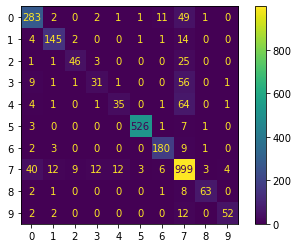

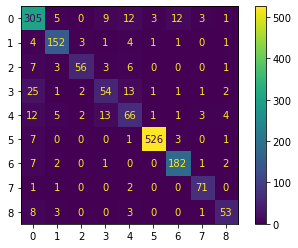

In [13]:
# test implementation when test file given
# this is a FAKE test file, just parts of our train data (results inaccurate from this, just to test func)


try:
    print('========================= Test Model With Neutrals =========================')
    EmotionClassifierObject.preprocess_test_corpus('T1_test.csv')
    #EmotionClassifierObjectNoNeutral.print_training_stats()
    EmotionClassifierObject.test_model(c_mx = True)
except Exception:
    pass
try:
    print('========================= Test Model Without Neutrals =========================')
    EmotionClassifierObjectNoNeutral.preprocess_test_corpus('T1_test.csv', exclude_neutral= True) 
    #EmotionClassifierObjectNoNeutral.print_training_stats()
    EmotionClassifierObjectNoNeutral.test_model(c_mx = True)
except Exception:
    pass

In [ ]:
'''
ec_wrapperobj = EmotionClassifiers('T1_train.csv', 'T1_test.csv')
ec_wrapperobj.train_models()
pickle_object_save(ec_wrapperobj, 'EmotionClassifiers.pkl')


EmotionClassifiers = None
with open('EmotionClassifiers.pkl', 'rb') as inp:
  EmotionClassifiers = pickle.load(inp)


EmotionClassifiers.test_models_and_print_stats()

'''